In [1]:
from pippi.oscs import Osc, Osc2d, Pulsar, Pulsar2d, Alias, Bar
from pippi import dsp, interpolation, wavetables, fx, oscs,soundpipe
from pippi.soundbuffer import SoundBuffer
from pippi.wavesets import Waveset
from pippi import dsp, fx
import random
import sounddevice as sd
from IPython.display import Audio
import librosa as lib
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from pippi import dsp, noise
import scipy
from helpers import *
import param_generation as pg
sr=48000
sd.default.samplerate = sr
plt.figure(figsize=(8, 5))



<Figure size 576x360 with 0 Axes>

<Figure size 576x360 with 0 Axes>

In [5]:
length = 3
osc = Osc("saw", freq=50.0)
out = osc.play(length).adsr(a=1, d=1, s=0, r=0)
out=lib.to_mono(np.transpose(np.array(out)))
# sd.play(out,blocking=True)

# Filter requirements.
order = 6
fs = sr       # sample rate, Hz
cutoff = 100  # desired cutoff frequency of the filter, Hz
y = butter_lowpass_filter(out, cutoff, fs, order)
sd.play(y)

<Figure size 576x360 with 0 Axes>

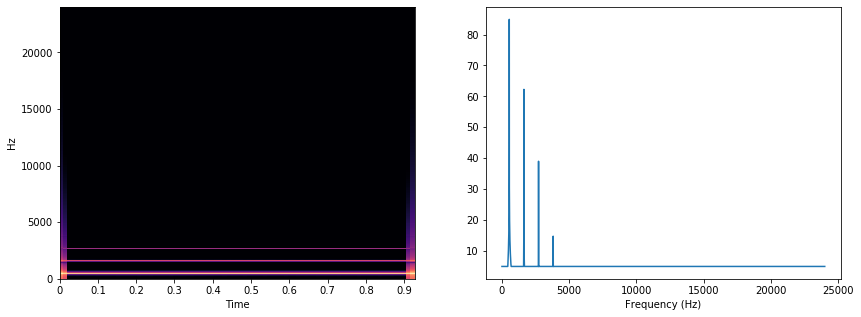

In [6]:
t = np.linspace(0, 2, num=44100)
wavetable = np.sin(np.sin(np.sin(500 * np.pi * t)))
wavetable2 = np.sin(500 * np.pi * t)
sd.play(wavetable,blocking=True)
specShow(wavetable)

##### Here's a bunch of synth examples:

CPU times: user 937 ms, sys: 21.1 ms, total: 958 ms
Wall time: 956 ms


<Figure size 576x360 with 0 Axes>

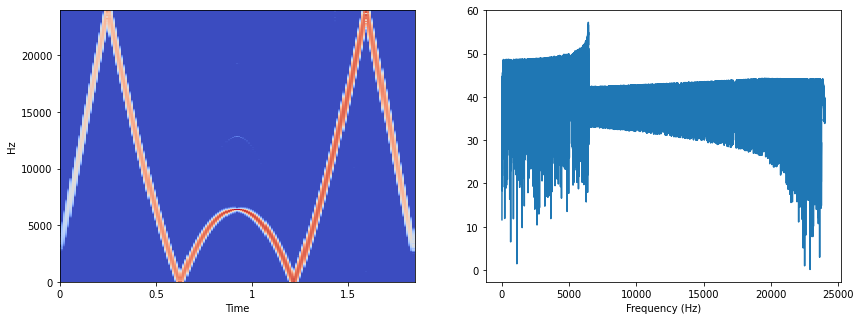

In [48]:
%%time
length = 2
osc = Osc('sine', freq=dsp.win('sine', 2500, 50000))
out = osc.play(length).adsr(a=10, d=1, s=0.5, r=1)
sd.play(out)
specShow(out)


<Figure size 576x360 with 0 Axes>

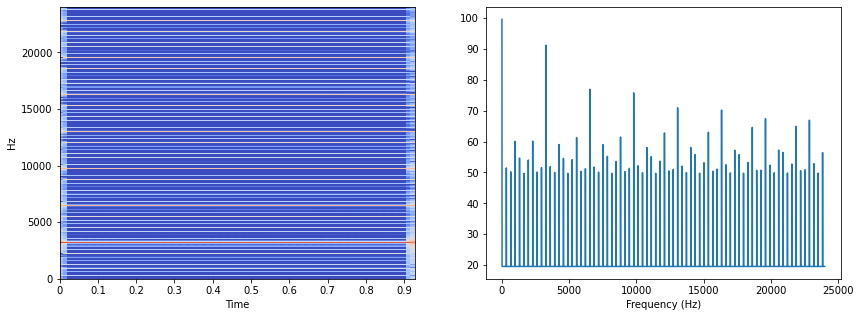

In [49]:
length = 1
wtA = [random.random() for _ in range(random.randint(1, 2)) ]
osc = Osc([3,0.3,5], freq=300.0)
out = osc.play(length)
sd.play(out,blocking=True)
specShow(out)


<Figure size 576x360 with 0 Axes>

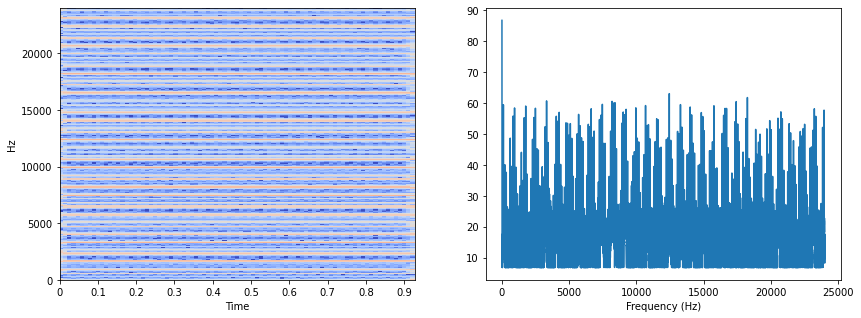

In [37]:
#randomly generated wavetable
wtA = [ random.random() for _ in range(random.randint(10, 1000)) ]
osc = Osc(wtA, freq=40.0)
length = 1
out = osc.play(length)
sd.play(out)
specShow(out)

In [39]:
length = 3
out = dsp.buffer(length=length)

lowf = dsp.win('rnd', 40, 1000)
highf = dsp.win('rnd', 1000, 15000)
out = noise.bln('sine', 2, 30,20000 )
# sd.play(out)
# specShow(out)
out

SoundBuffer(samplerate=44100, channels=2, frames=<MemoryView of '_memoryviewslice' object>)

<Figure size 576x360 with 0 Axes>

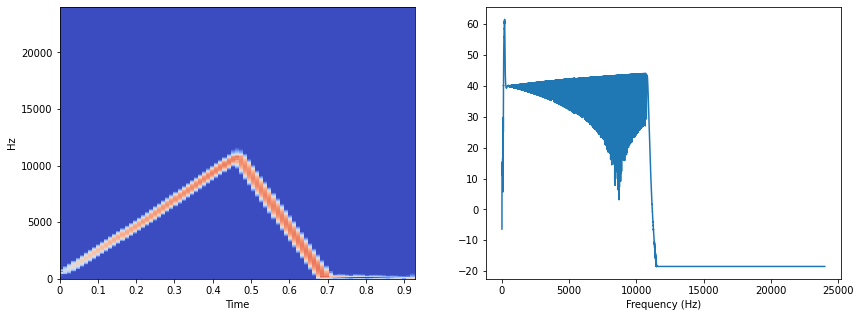

In [38]:
length = 1
osc = Osc("cos", freq=[400.0,5000,10000,200,100])
out = osc.play(length).adsr(a=10, d=1, s=0.5, r=1)
sd.play(out)
specShow(out)


<Figure size 576x360 with 0 Axes>

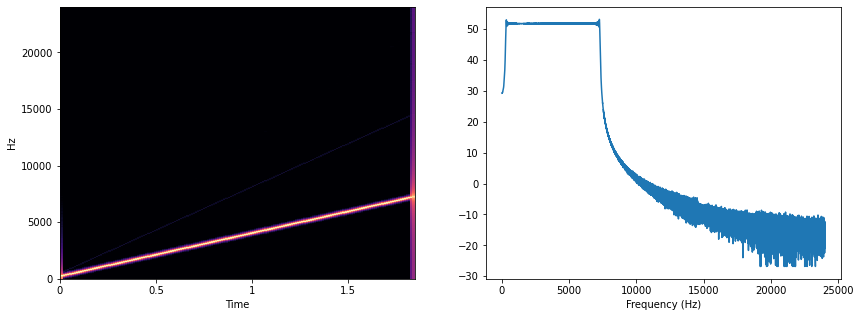

In [9]:
length = 2
a=dsp.win('saw', 250, 6700)
osc = Osc("sine", freq=a,channels=1)
out = osc.play(length)
# print(out)
sd.play(out)
specShow(out)


40000

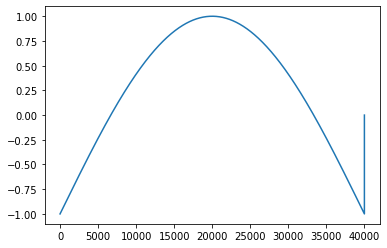

In [8]:
#how do windows work?
a=dsp.win('sine', -1, 1,40000)
plt.plot(a)
len(a)

#### some effects

<Figure size 576x360 with 0 Axes>

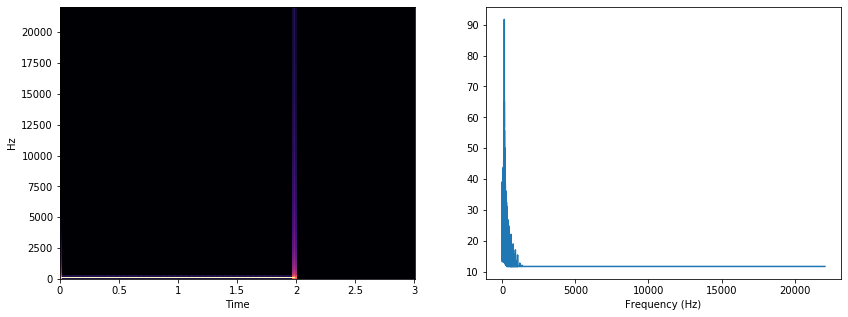

In [7]:
# no idea how vspeed works. What does the lfo do? 
length = 3
osc = Osc("sine", freq=100,channels=2)
out = osc.play(length)
lfo = dsp.win('saw', 100000)
snd = fx.vspeed(out, lfo, -1,1)
snd = fx.norm(snd, 1)
sd.play(snd.frames,samplerate=44100,blocking=True)
specShow(np.asarray(snd.frames))

<Figure size 576x360 with 0 Axes>

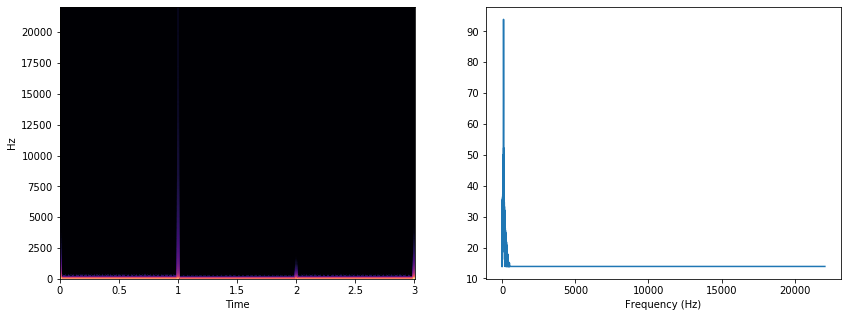

In [8]:
# delay
length = 3
osc = Osc("sine", freq=100,channels=1)
out = osc.play(length)
out = fx.delay(out, 1, 0.5)
out=fx.norm(out,1)
sd.play(out,blocking=True)
specShow(out)
# print(out[1])

3.000000001775773


2

<Figure size 576x360 with 0 Axes>

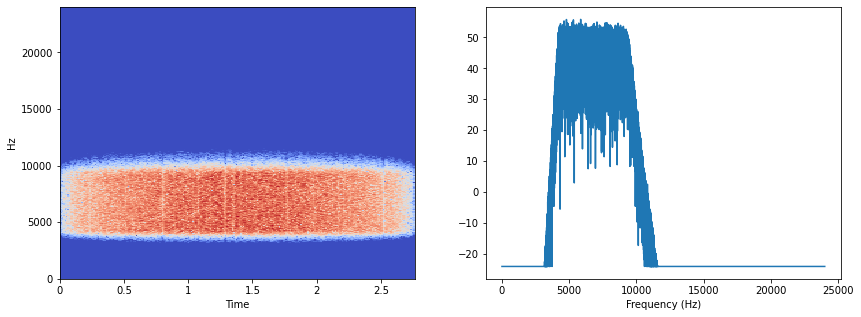

In [60]:
p=pg.RandomParams()
pg.min_length = 3.0
print(p.getLength())

s=pg.Synth(p)
specShow(s.buff)
sd.play(s.buff)

p.length

48000
3.000000000001734
CPU times: user 1.73 s, sys: 50.8 ms, total: 1.78 s
Wall time: 1.84 s


<Figure size 576x360 with 0 Axes>

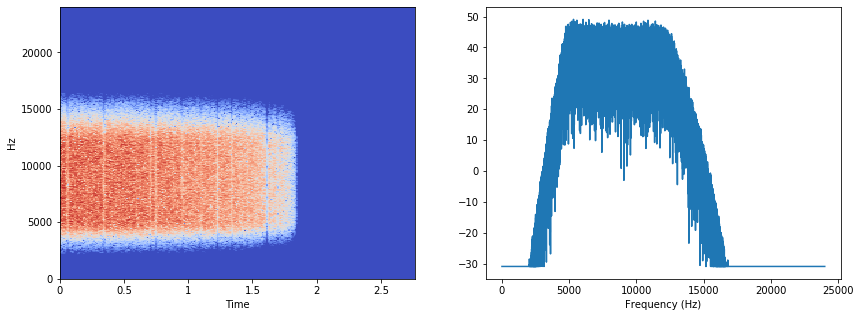

In [2]:
%%time
print(sr)
out = dsp.buffer(length=5)
p=pg.RandomParams()
pg.min_length = 3.0
print(p.getLength())

s=pg.Synth(p)
specShow(s.buff)
out.dub(s.buff,1.0)
sd.play(out)


In [107]:
pool = []
pg.min_length = 3.0
for i in range(7):
    p=pg.RandomParams()
    s=pg.Synth(p)
    pool.append(s)

In [108]:
import librosa

def mfcc(audio, nwin=256, nfft=512, fs=16000, nceps=13):
    #return librosa.feature.mfcc(y=audio, sr=44100, hop_length=nwin, n_mfcc=nceps)
    return [np.transpose(librosa.feature.mfcc(y=audio, sr=fs, n_fft=nfft, win_length=nwin,n_mfcc=nceps))]

def add_feature(mfcc1, rmsa1):
    tmfcc1 = np.zeros((mfcc1.shape[0],mfcc1.shape[1]+rmsa1.shape[0]))
    n = mfcc1.shape[0]
    m = mfcc1.shape[1]
    w = rmsa1.shape[0]
    tmfcc1[0:n,0:m] = mfcc1[0:n,0:m]
    tmfcc1[0:n,m:m+w]   = np.transpose(rmsa1[0:w,0:n])
    return tmfcc1

def std_mfcc(mfcc):
    return (mfcc - np.mean(mfcc, axis=0)) / np.std(mfcc, axis=0)

def calc_features(a1):
    fs = sr
    mfcc1 = mfcc(a1, nwin=256, nfft=512, fs=fs, nceps=26)[0]
    mfcc1 = std_mfcc(mfcc1)
    rmsa1 = librosa.feature.rms(a1)
    cent1 = librosa.feature.spectral_centroid(y=a1, sr=fs)
    rolloff1 = librosa.feature.spectral_rolloff(y=a1, sr=fs, roll_percent=0.1)
    chroma_cq1 = librosa.feature.chroma_cqt(y=a1, sr=fs, n_chroma=10)
    onset_env1 = librosa.onset.onset_strength(y=a1, sr=sr)
    try:
        pulse1 = librosa.beat.plp(onset_envelope=onset_env1, sr=sr)
    except:
        pulse1 = np.ones((mfcc1.shape[0],))
    mfcc1 = add_feature(mfcc1, rmsa1)
    mfcc1 = add_feature(mfcc1, rolloff1/fs)
    mfcc1 = add_feature(mfcc1, cent1/fs)
    mfcc1 = add_feature(mfcc1, chroma_cq1)
    mfcc1 = add_feature(mfcc1, onset_env1.reshape(1,onset_env1.shape[0]))
    mfcc1 = add_feature(mfcc1, pulse1.reshape(1,onset_env1.shape[0]))
    return mfcc1

def cross_correlation(mfcc1, mfcc2, nframes):
    n1, mdim1 = mfcc1.shape
    n2, mdim2 = mfcc2.shape
    #print((nframes,(n1,mdim1),(n2,mdim2)))
    if (n2 <= nframes):
        t = np.zeros((nframes,mdim2))
        t[0:n2,0:mdim2] = mfcc2[0:n2,0:mdim2]
        mfcc2 = t
    if (n1 < nframes):
        t = np.zeros((nframes,mdim1))
        t[0:n1,0:mdim1] = mfcc2[0:n1,0:mdim1]
        mfcc1 = t
        n1 = nframes
    n = n1 - nframes + 1
    #c = np.zeros(min(n2,n))
    c = np.zeros(n)
    #for k in range(min(n2,n)):
    for k in range(n):
        cc = np.sum(np.multiply(mfcc1[k:k+nframes], mfcc2[:nframes]), axis=0)
        c[k] = np.linalg.norm(cc,1)
    return c



def rosa_compare(a1, a2, fs=48000, trim=60*15, correl_nframes=50, plotit=True):
    sr = fs
    #print("Ref samples: %s Find samples: %s" % (a1.shape[0],a2.shape[0]))
    mfcc1 = calc_features(a1)
    mfcc2 = calc_features(a2)
    #mfcc1 = mfcc(a1, nwin=256, nfft=512, fs=fs, nceps=26)[0]
    #mfcc2 = mfcc(a2, nwin=256, nfft=512, fs=fs, nceps=26)[0]
    c = cross_correlation(mfcc1, mfcc2, nframes=correl_nframes)
    max_k_index = np.argmax(c)
    # offset = max_k_index * (a1.shape[0]/rmsa1.shape[1]) / float(fs) # * over / sample rate
    #print("Best matching window: %s" % max_k_index)
    #print("mean %s std %s" % (np.mean(c) , np.std(c)))
    score = (c[max_k_index] - np.mean(c)) / (0.0000001 + np.std(c)) # standard score of peak
    return score



In [ ]:
input_snd = dsp.read('tritrack.wav')

x = np.asarray(s.buff.frames[0:,0])
y = np.asarray(input_snd.frames[0:x.shape[0],0])
print(x.shape)
print(y.shape)
#print(librosa.feature.mfcc(y=x))

print(rosa_compare(x,x))
for i in range(20):
    nx = x.shape[0]
    y = np.asarray(input_snd.frames[nx*i:nx*(i+1),0])
    print("%s %s" % (i,rosa_compare(x,y)))

In [109]:
input_snd = dsp.read('tritrack.wav')
tritrackseconds = 10
tritracksim = np.zeros((tritrackseconds,len(pool)))
for second in range(tritrackseconds):
    start = sr * second
    y = np.asarray(input_snd.frames[start:(start+3*sr),0])
    for i in range(len(pool)):
        x = np.asarray(pool[i].buff.frames[0:,0])        
        v = rosa_compare(x,y)
        tritracksim[second,i] = v
        print("second: %s i: %s v: %s" % (second,i, v))
tritracksim

second: 0 i: 0 v: 4.611870960981704
second: 0 i: 1 v: 4.532994083454586
second: 0 i: 2 v: 3.4376690155407976
second: 0 i: 3 v: 2.350529723318219
second: 0 i: 4 v: 1.920265028477945
second: 0 i: 5 v: 2.6555613651303074
second: 0 i: 6 v: 1.2460445442353139
second: 1 i: 0 v: 3.7209604768851436
second: 1 i: 1 v: 2.1744182378818615
second: 1 i: 2 v: 3.0110771491529307
second: 1 i: 3 v: 2.5430714871804994
second: 1 i: 4 v: 2.1941648423876554
second: 1 i: 5 v: 2.0413518493343554
second: 1 i: 6 v: 1.6039994005788747
second: 2 i: 0 v: 2.822666603106947
second: 2 i: 1 v: 3.578212273017333
second: 2 i: 2 v: 4.370820578153549
second: 2 i: 3 v: 2.2918496745987946
second: 2 i: 4 v: 1.7827246673050068
second: 2 i: 5 v: 2.4666700825545442
second: 2 i: 6 v: 1.6559402615678291
second: 3 i: 0 v: 3.9763829787226848
second: 3 i: 1 v: 3.063487961593354
second: 3 i: 2 v: 4.163110509938635
second: 3 i: 3 v: 2.500067361952316
second: 3 i: 4 v: 2.5338557708173686
second: 3 i: 5 v: 1.9150066709925244
second: 3 i

array([[4.61187096, 4.53299408, 3.43766902, 2.35052972, 1.92026503,
        2.65556137, 1.24604454],
       [3.72096048, 2.17441824, 3.01107715, 2.54307149, 2.19416484,
        2.04135185, 1.6039994 ],
       [2.8226666 , 3.57821227, 4.37082058, 2.29184967, 1.78272467,
        2.46667008, 1.65594026],
       [3.97638298, 3.06348796, 4.16311051, 2.50006736, 2.53385577,
        1.91500667, 1.65989239],
       [4.70563192, 2.59869332, 3.38528496, 2.90913293, 3.13159774,
        2.27751369, 1.77541168],
       [3.92488032, 2.31927938, 3.11012285, 2.31080209, 1.46985754,
        2.28260663, 2.06823625],
       [3.73103384, 2.68311814, 3.19792979, 2.38227678, 1.55522784,
        2.31756499, 2.28595175],
       [2.85457189, 3.64451115, 3.58270046, 2.20774225, 1.69562442,
        3.03189575, 1.38772214],
       [4.170429  , 2.49157805, 3.38262753, 2.75832748, 1.99665773,
        1.78853783, 1.7257119 ],
       [4.74308954, 3.92758117, 3.4435586 , 1.9410432 , 1.89791406,
        1.8706524 , 1.5

In [115]:
for i in np.argmax(tritracksim,axis=1):
    sd.play(pool[i].buff)


In [64]:
%%time

out = dsp.buffer(length=1)
for i in range(1): 
    p=pg.RandomParams()
    s=pg.Synth(p)
    out.dub(s.buff,p.start)

sd.play(out)
specShow(out)

KeyboardInterrupt: 

<Figure size 576x360 with 0 Axes>